In [32]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import date,timedelta

In [36]:
def stock_predictor(ticker,start,end,epochs):
    
    df = web.DataReader(ticker, data_source='yahoo', start=start, end=end)
    print('_'*100)
    print('Number of market days:',df.shape[0])    
    # creating a new dataframe only with close price column
    newdf = df.filter(['Close'])
    
    dataset = newdf.values
    
    training_data_len = math.ceil( len(dataset) *0.8)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(dataset)
    
    train_data = scaled_data[0:training_data_len, :]
    
    x_train = [] # independent data
    y_train = [] # dependent data, deends on x_train
    
    for data in range(60, len(train_data)):
        x_train.append(train_data[data-60:data, 0])
        y_train.append(train_data[data,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    print('LSTM Fitting:')
    model.fit(x_train, y_train, batch_size=1, epochs=epochs)
    
    test_data = scaled_data[training_data_len-60: , :]
    
    x_test = []
    y_test = dataset[training_data_len:, :]
    
    for tdata in range(60, len(test_data)):
        x_test.append(test_data[tdata-60:tdata, 0])
        
    x_test = np.array(x_test)
    
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    # model predicted price
    
    predictions = model.predict(x_test)
    
    # inverse transform the data 
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt( np.mean(predictions - y_test)**2)
    print('_'*100)

    print('Root Mean Squared Error:',rmse)
    
    train = newdf[:training_data_len]
    # validation dataset
    valid = newdf[training_data_len:]
    valid['predictions'] = predictions
    # visualizing the data
    plt.figure(figsize=(16, 8))
    plt.title('Model Visualization')
    plt.xlabel('Data', fontsize=18)
    plt.ylabel('Closed Price', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'predictions']])
    plt.legend(['train', 'validation', 'prediction'], loc='lower right')
    plt.show()
    print(valid.tail(2))
    return

____________________________________________________________________________________________________
Number of market days: 2013
LSTM Fitting:
Epoch 1/1
1551/1551 [==============================] - 88s 57ms/step - loss: 8.0435e-04
____________________________________________________________________________________________________
Root Mean Squared Error: 3.473566539251982


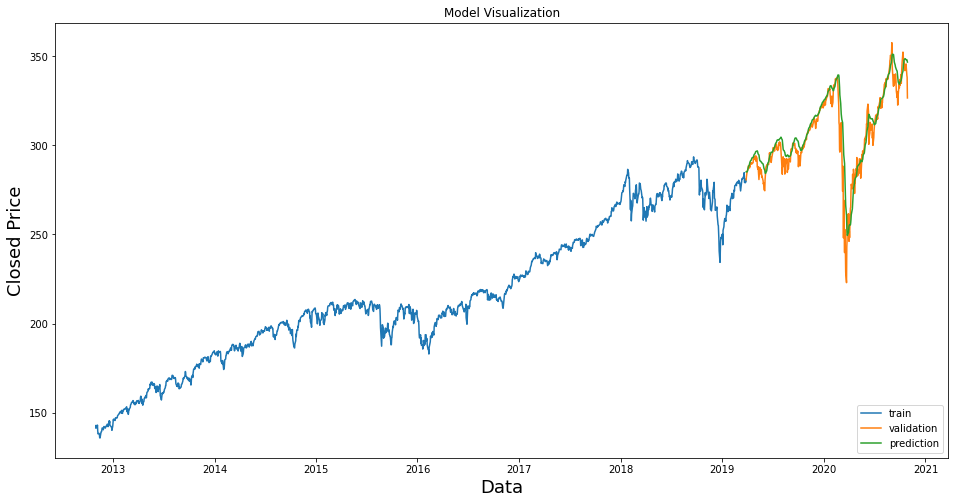

                 Close  predictions
Date                               
2020-10-27  338.220001   347.593903
2020-10-28  326.660004   346.817261


In [40]:
stock_predictor('SPY',
                # by default 8 years ago aka more or less 2013 days of market
                start=(date.today() - timedelta(days=2920)).strftime("%Y/%m/%d"),
                # by default current date
                end = date.today().strftime("%Y/%m/%d"),
                # number of epochs for training LSTM
                epochs=1)